# Save super resolution image

2024-06-11 19:28:33.361624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 19:28:33.361798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 19:28:33.581483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


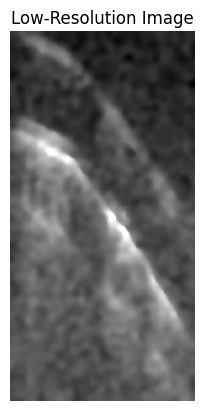

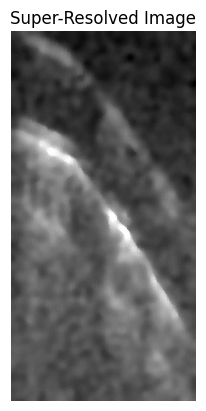

Super-resolved image saved at: /kaggle/working/super_resolved_image.jpg


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

# Function to load a black and white image
def load_bw_image(path):
    image = PIL.Image.open(path).convert('L')  # Convert image to grayscale
    return np.array(image)

# Function to plot images
def plot_image(image, title=''):
    plt.imshow(image, cmap='gray')  # Use gray colormap for black and white images
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load a pre-trained SRGAN model from TensorFlow Hub
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

# Load your low-resolution black and white image
lr_image_path = '/kaggle/input/contrastenhancedimg/ProcessedImages/output1/RawDataQA (1)/(1).tif'
lr_image = load_bw_image(lr_image_path)

# Convert the image to float32 format
lr_image = tf.convert_to_tensor(lr_image, dtype=tf.float32)

# Duplicate the grayscale channel three times to create a pseudo-RGB image
lr_image = tf.stack([lr_image, lr_image, lr_image], axis=-1)

# Add a batch dimension
lr_image = tf.expand_dims(lr_image, axis=0)

# Super-resolve the image using the SRGAN model
sr_image = model(lr_image)

# Remove the batch dimension and convert back to uint8
sr_image = tf.squeeze(sr_image)
sr_image = tf.clip_by_value(sr_image, 0, 255)
sr_image = tf.cast(sr_image, tf.uint8).numpy()

# Since the output is in RGB, convert it back to grayscale by averaging the color channels
sr_image_bw = np.mean(sr_image, axis=-1).astype(np.uint8)

# Plot the original and super-resolved images
plot_image(lr_image[0, :, :, 0].numpy().astype(np.uint8), title='Low-Resolution Image')
plot_image(sr_image_bw, title='Super-Resolved Image')

# Save the super-resolved image
output_path = '/kaggle/working/super_resolved_image.jpg'
PIL.Image.fromarray(sr_image_bw).save(output_path)
print(f"Super-resolved image saved at: {output_path}")


In [2]:
import cv2
import numpy as np

def mean_squared_roughness(image):
    mean_value = np.mean(image)
    msr = np.mean((image - mean_value) ** 2)
    return msr

def calculate_cnr(roi_a, roi_b):
    mean_a = np.mean(roi_a)
    mean_b = np.mean(roi_b)
    std_a = np.std(roi_a)
    std_b = np.std(roi_b)
    cnr = np.abs(mean_a - mean_b) / np.sqrt(std_a**2 + std_b**2)
    return cnr

# Load images
original =lr_image
processed =sr_image_bw

# Calculate MSR for original and processed images
msr_original = mean_squared_roughness(original)
msr_processed = mean_squared_roughness(processed)


roi_a = processed[50:100, 50:100]  
roi_b = processed[150:200, 150:200]  

cnr_value = calculate_cnr(roi_a, roi_b)

print("MSR (Original):", msr_original)
print("MSR (Processed):", msr_processed)
print("CNR:", cnr_value)


MSR (Original): 1459.7078
MSR (Processed): 1461.239370714952
CNR: 0.27494347771346567
